In [1]:
import cv2
import numpy as np
import  matplotlib.pyplot as plt
import math
from scipy.optimize import linear_sum_assignment
import random
%matplotlib inline

In [2]:
def imshow(img):
    """
    jupyter 内部可视化图像
    """
    plt.axis('off')
    # 3通道图像应从BGR转RGB再显示
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    # 灰度图应转为RGB
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

## 案例图片

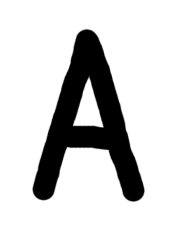

In [3]:
img1 = cv2.imread("input/A.png")
imshow(img1)

In [4]:
def Edge_detection(img, kernel_size=(3,3), thresh1=50, thresh2=150):
    """
    边缘检测算法
    1. 高斯滤波平滑图像
    2. Canny算子检测边缘
    """
    img = cv2.GaussianBlur(img,kernel_size,0)
    canny = cv2.Canny(img, thresh1, thresh2)
    return canny

## 边缘检测示例：

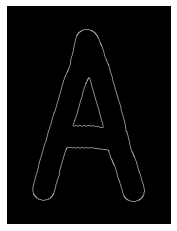

In [5]:
img1 = cv2.imread("input/A.png")
im = Edge_detection(img1)
imshow(im)

In [6]:
def Jitendra_Sample(points, N=100, k=3):
    """
    Jitendra’s sampling
    points: 样本点，shape为[I, 2]，其中I为点的个数
    N: 采样的点的数目
    k: 阈值
    """
    # 样本点个数
    I = points.shape[0]
    # 首先需要对样本点进行乱序
    points = np.random.permutation(points)

    NStart = min(k*N, I)
    # 阈值
    if I > k * N:
        NStart_sample_points = points[:NStart]
    # 计算欧式距离矩阵
    dist = np.sqrt(np.sum(np.square(NStart_sample_points.reshape((1,NStart,2)) - NStart_sample_points.reshape((NStart,1,2))), axis=-1)) + np.eye(NStart, dtype=int) * 999999999999
    
    # 迭代，删到只剩N个点
    for num in range(NStart-N):
        # 将该点删去，实现是设置为很大
        # i = np.where(dist == np.min(dist))[0][0]
        j = np.where(dist == np.min(dist))[1][0]
        dist[j,:] = 999999999999; dist[:,j] = 999999999999

    # 获取序列，注意去重
    i = np.unique(np.where(dist < 999999999999)[0])
    sample_points = NStart_sample_points[i]
    return sample_points

## 随机采样

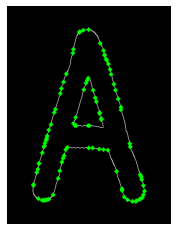

In [7]:
img1 = cv2.imread("input/A.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
points = np.random.permutation(points)

img = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
for i in range(100):
    cv2.circle(img, (points[i][1],points[i][0]), 2, [0,255,0],4)
imshow(img)

## Jitendra采样示意

In [8]:
img1 = cv2.imread("input/A.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points = Jitendra_Sample(points, N=100, k=3)

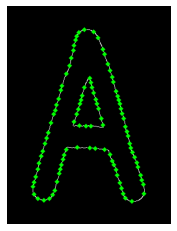

In [9]:
img = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

for point in sample_points:
	cv2.circle(img, (point[1],point[0]), 2, [0,255,0],4)
imshow(img)

In [10]:
def Shape_Context(points, angle=12, distance=[0,0.125,0.25,0.5,1.0,2.0]):
    """
    形状上下文直方图矩阵的构建
    points: 输入的采样点 shape[N,2]
    angle:  划分的角度区域个数
    distance: 划分的距离区域
    """
    # 计算欧式距离矩阵
    N = points.shape[0]
    dist = np.sqrt(np.sum(np.square(points.reshape((1,N,2)) - points.reshape((N,1,2))), axis=-1))
    
    # 距离均值
    mean_dist = np.sum(dist) / (N*N-N)
    # 除以均值，减少缩放敏感性
    dist = np.log(dist/mean_dist+0.000000000001) + np.eye(N, dtype=int) * 999
    # print(dist)

    # 角度计算
    theta = np.arctan((points[:,1].reshape(1,N)-points[:,1].reshape(N,1))/(points[:,0].reshape(1,N)-points[:,0].reshape(N,1)+0.000000000001))/math.pi + ((points[:,0].reshape(1,N)-points[:,0].reshape(N,1))<0).astype(int) + 0.5   # range(0, 2)

    histogram_feature = np.zeros((N, angle, len(distance)))

    for i in range(angle):
        # angle range
        angle_matrix = (theta > (2/angle * i)) * (theta <= (2/angle * (i+1)))
        for j in range(1,len(distance)):
            distance_matrix = (dist < distance[j]) * (dist > distance[j-1])

            histogram_feature[:,i,j-1] = np.sum(angle_matrix * distance_matrix, axis = 1)
    return histogram_feature

## Shape Context获取

In [11]:
img1 = cv2.imread("input/A.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points = Jitendra_Sample(points, N=100, k=3)

histogram_feature = Shape_Context(sample_points)

## 随机抽取点，可视化点上下文特征

In [12]:
def visualization(img_path, sample_points, index):
    """
    可视化
    """
    for i in range(len(index)):
        img = cv2.imread(img_path)
        img = Edge_detection(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        for point in sample_points:
            cv2.circle(img, (point[1],point[0]), 2, [0,255,0],4)
        cv2.circle(img, (sample_points[i][1],sample_points[i][0]), 4, [255,0,0],6)
        plt.subplot(2,len(index),i+1)
        plt.axis('off')
        plt.imshow(img)
        
        plt.subplot(2,len(index),i+1+len(index))
        plt.axis('off')
        plt.imshow(histogram_feature[index[i]].astype(np.uint8))
    plt.show()

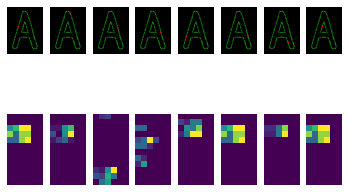

In [13]:
visualization("input/A.png", sample_points, index=[12,74,42,23,63,12,53,12])

## 形状代价矩阵

In [14]:
def Cost_function_Shape_Context(histogram1, histogram2):
    """
    代价矩阵
    histogram1: N1*A*D
    histogram2: N2*A*D
    """
    A = histogram1.shape[1]
    D = histogram1.shape[2]
    N1 = histogram1.shape[0]
    N2 = histogram2.shape[0]
    assert histogram1.shape[1] == histogram2.shape[1]
    assert histogram1.shape[2] == histogram2.shape[2]
    cost = 0.5 * np.sum(np.sum(
        np.square(
            histogram1.reshape((N1,1,A,D)) - histogram2.reshape((1,N2,A,D))) / (histogram1.reshape((N1,1,A,D)) + histogram2.reshape((1,N2,A,D))+0.000000001)
        ,axis=-1),axis=-1)
    return cost

## 局部外观代价矩阵

In [15]:
def Cost_function_Local_Appearance(img1, img2, sample_points1, sample_points2):
    """
    Local Appearance
    """
    N1 = sample_points1.shape[0]
    N2 = sample_points2.shape[0]

    img1gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    sobel1_x = cv2.Sobel(img1gray,cv2.CV_64F,1,0,ksize=3)
    sobel1_y = cv2.Sobel(img1gray,cv2.CV_64F,0,1,ksize=3)

    sobel2_x = cv2.Sobel(img2gray,cv2.CV_64F,1,0,ksize=3)
    sobel2_y = cv2.Sobel(img2gray,cv2.CV_64F,0,1,ksize=3)
    
    cos1 = sobel1_x[sample_points1[:,0],sample_points1[:,1]]
    cos2 = sobel2_x[sample_points2[:,0],sample_points2[:,1]]
    sin1 = sobel1_y[sample_points1[:,0],sample_points1[:,1]]
    sin2 = sobel2_y[sample_points2[:,0],sample_points2[:,1]]

    cost = 0.5 * np.sqrt(
        np.square(cos2.reshape(1,N2) -cos1.reshape(N1,1)) + np.square(sin2.reshape(1,N2) -sin1.reshape(N1,1))
    )
    return cost

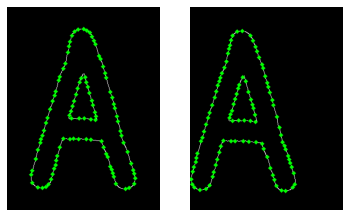

In [16]:
N = 100
angle = 12

img1 = cv2.imread("input/A.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points1 = Jitendra_Sample(points, N=N, k=3)
# 画点
img = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
for point in sample_points1:
	cv2.circle(img, (point[1],point[0]), 2, [0,255,0],4)
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)
histogram_feature1 = Shape_Context(sample_points1, angle)

img2 = cv2.imread("input/A2.png")
im = Edge_detection(img2)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points2 = Jitendra_Sample(points, N=100, k=3)
# 画点
img = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
for point in sample_points2:
	cv2.circle(img, (point[1],point[0]), 2, [0,255,0],4)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img)
histogram_feature2 = Shape_Context(sample_points2, angle)

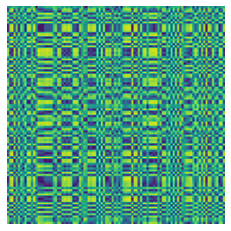

In [17]:
cost_matrix = Cost_function_Shape_Context(histogram_feature1, histogram_feature2) + Cost_function_Local_Appearance(img1, img2, sample_points1, sample_points2)
plt.axis('off')
plt.imshow(cost_matrix)

In [18]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)
match = np.array([[x,y] for x,y in zip(row_ind,col_ind)])

In [19]:
def drawmatch(img_path1, img_path2, points1, points2, match, visual_num=20):
    """
    可视化匹配图像
    img_path1: 图像1的路径
    img_path2: 图像2的路径
    points1: 图像1的点坐标 (N1,2)
    points2: 图像2的点坐标 (N2,2)
    match: 匹配点索引对 (N3,2)
    visual_num: 可视化的点数目，随机抽点
    """
    img1 = cv2.imread(img_path1); img2 = cv2.imread(img_path2)

    # image2高度与image1一致对齐：
    img2 = cv2.resize(img2, (int(img1.shape[0]/img2.shape[0]*img2.shape[1]), img1.shape[0]))
    points2 = points2 * img1.shape[0] / img2.shape[0]
    points2[:, 1] +=  img1.shape[1]
    points2 = points2.astype(np.int32)

    # 拼接图像
    new_img = np.zeros([img1.shape[0], img1.shape[1]+img2.shape[1], 3])
    new_img[:,:img1.shape[1]] = img1
    new_img[:,img1.shape[1]:] = img2

    # 随机采样点
    match = np.random.permutation(match)
    for i in range(visual_num):
        # 随机颜色
        color = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        new_img = cv2.circle(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)
        new_img = cv2.circle(new_img, (points2[match[i][1]][1], points2[match[i][1]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)

        new_img = cv2.line(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), (points2[match[i][1]][1], points2[match[i][1]][0]), color, 1)

    new_img = new_img.astype(np.uint8)

    imshow(new_img)

In [20]:
def drawmatch_(img1, img2, points1, points2, match, visual_num=20):
    """
    可视化匹配图像
    img1: 图像1
    img2: 图像2
    points1: 图像1的点坐标 (N1,2)
    points2: 图像2的点坐标 (N2,2)
    match: 匹配点索引对 (N3,2)
    visual_num: 可视化的点数目，随机抽点
    """
    # 拼接图像
    new_img = np.zeros([img1.shape[0], img1.shape[1]+img2.shape[1], 3])
    new_img[:,:img1.shape[1]] = img1
    new_img[:,img1.shape[1]:] = img2

    points2[:, 1] +=  img1.shape[1]
    points2 = points2.astype(np.int32)

    # 随机采样点
    match = np.random.permutation(match)
    for i in range(visual_num):
        # 随机颜色
        color = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        new_img = cv2.circle(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)
        new_img = cv2.circle(new_img, (points2[match[i][1]][1], points2[match[i][1]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)

        new_img = cv2.line(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), (points2[match[i][1]][1], points2[match[i][1]][0]), color, 1)

    new_img = new_img.astype(np.uint8)

    imshow(new_img)
    cv2.imwrite("result.jpg", new_img)

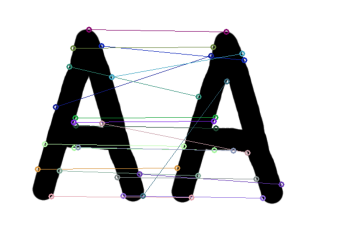

In [21]:
drawmatch(img_path1="input/A.png", img_path2="input/A2.png", points1 = sample_points1, points2 = sample_points2, match = match, visual_num=20)

In [22]:
def context_shape_match(path1, path2, visual_num=30, N=100, angle=12, distance=[0,0.125,0.25,0.5,1.0,2.0]):
    """
    图形匹配
    path1: 图片路径1
    path2: 图片路径2
    N: 采样点数
    angle: 上下文极坐标角度划分个数
    """
    # 读取图片
    img1 = cv2.imread(path1)
    # 边缘检测
    im = Edge_detection(img1)
    # 采样点
    points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
    sample_points1 = Jitendra_Sample(points, N=N, k=3)
    # sample_points1 = np.random.permutation(points)[:N]
    # 上下文直方图
    histogram_feature1 = Shape_Context(sample_points1, angle, distance)

    # 读取图片
    img2 = cv2.imread(path2)
    # image2高度与image1一致对齐：
    img2 = cv2.resize(img2, (int(img1.shape[0]/img2.shape[0]*img2.shape[1]), img1.shape[0]))
    # 边缘检测
    im = Edge_detection(img2)
    # 采样点
    points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
    sample_points2 = Jitendra_Sample(points, N=N, k=3)
    # sample_points2 = np.random.permutation(points)[:N]
    # 上下文直方图
    histogram_feature2 = Shape_Context(sample_points2, angle, distance)

    # 代价矩阵
    # cost_matrix = Cost_function(histogram_feature1, histogram_feature2)
    cost_matrix = 0.5 * Cost_function_Shape_Context(histogram_feature1, histogram_feature2) + 0.5 * Cost_function_Local_Appearance(img1, img2, sample_points1, sample_points2)

    # 匈牙利匹配
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    match = np.array([[x,y] for x,y in zip(row_ind,col_ind)])

    # 可视化
    drawmatch_(img1=img1, img2=img2, points1 = sample_points1, points2 = sample_points2, match = match, visual_num=visual_num)

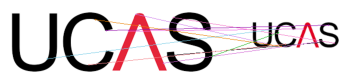

In [23]:
context_shape_match("input/ucas-re.png","input/ucas3.png", visual_num=10, N=100, angle=16, distance=[0,0.125,0.25,0.5,1.0,2.0])

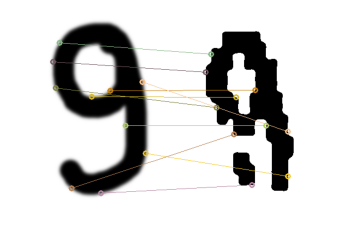

In [24]:
context_shape_match("input/9.png","input/9M.png", visual_num=10, N=100, angle=16, distance=[0,0.125,0.25,0.5,1.0,2.0])

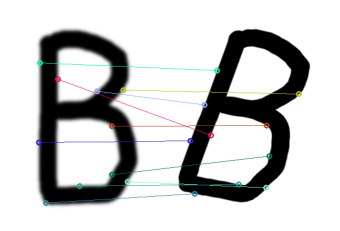

In [25]:
context_shape_match("input/B.png","input/BM.png", visual_num=10, N=100, angle=16, distance=[0,0.125,0.25,0.5,1.0,2.0])

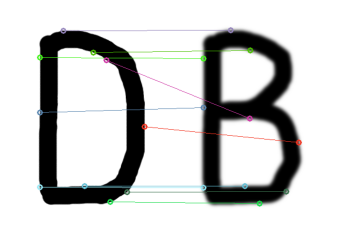

In [26]:
context_shape_match("input/D.png","input/B.png", visual_num=10, N=100, angle=16, distance=[0,0.125,0.25,0.5,1.0,2.0])

## 仿射变换

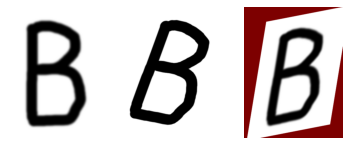

In [27]:
N = 100
angle = 12

img1 = cv2.imread("input/B.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points1 = Jitendra_Sample(points, N=N, k=3)
histogram_feature1 = Shape_Context(sample_points1, angle)

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img1)

img2 = cv2.imread("input/BM.png")
im = Edge_detection(img2)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points2 = Jitendra_Sample(points, N=200, k=3)
histogram_feature2 = Shape_Context(sample_points2, angle)

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img2)

cost_matrix = 0.5 * Cost_function_Shape_Context(histogram_feature1, histogram_feature2) + 0.5 * Cost_function_Local_Appearance(img1, img2, sample_points1, sample_points2)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
match = np.array([[x,y] for x,y in zip(row_ind,col_ind)])

original_position = []
new_position = []
# 仿射变换
match = np.random.permutation(match)
for i in range(3):
    original_position.append(sample_points1[match[i][0]])
    new_position.append(sample_points2[match[i][1]])
# 图像A的高度和宽度
h,w = img1.shape[:2]

original_position = np.array(original_position, np.float32)
new_position = np.array(new_position, np.float32)

A1 = cv2.getAffineTransform(original_position, new_position)
d1 = cv2.warpAffine(img1, A1, (w, h), borderValue = 125)

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(d1)

In [29]:
def tps_trans(p1,p2,gray,tps_lambda = 0.2):
    '''
    Thin-Plate Spline Transform Algorithm 

    input:
        p1 : feature points in the image to be transformed
        p2 : target feature points
        gray : input image
        tps_lambda : a tps parameter
    output:
        out_img : transformed input image
        new : transformed mark image, where shows transformed p1 points 
                (as cv2.applyTransformation() cannot work properly)
    '''
    tps = cv2.createThinPlateSplineShapeTransformer()
    tps.setRegularizationParameter(tps_lambda)
    matches = []
    new = np.zeros_like(gray)
    for i in range(len(p1[0])):
        matches.append(cv2.DMatch(i,i,0))
        # cv2.circle(new,[int(p1[0][i][0]),int(p1[0][i][1])],1,(1,0,0),-1)
    tps.estimateTransformation(p2, p1, matches)

    out_img = tps.warpImage(gray)
    print(tps.applyTransformation(p1))
    return out_img

In [ ]:
N = 100
angle = 12

img1 = cv2.imread("input/B.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points1 = Jitendra_Sample(points, N=N, k=3)
histogram_feature1 = Shape_Context(sample_points1, angle)

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img1)

img2 = cv2.imread("input/BM.png")
im = Edge_detection(img2)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points2 = Jitendra_Sample(points, N=200, k=3)
histogram_feature2 = Shape_Context(sample_points2, angle)

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img2)

cost_matrix = Cost_function(histogram_feature1, histogram_feature2)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
match = np.array([[x,y] for x,y in zip(row_ind,col_ind)])

original_position = []
new_position = []
# thin-plate spline transformer
match = np.random.permutation(match)
for i in range(len(sample_points1)):
    original_position.append([sample_points1[match[i][0]]])
    new_position.append([sample_points2[match[i][1]]])

original_position = np.array(original_position, np.float32)
new_position = np.array(new_position, np.float32)

tps_img = tps_trans(original_position, new_position, img1, tps_lambda = 0.2)


plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(tps_img)

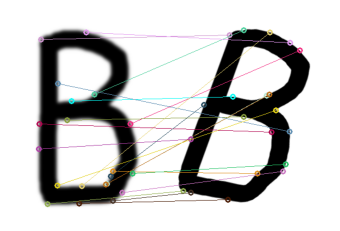

In [47]:
context_shape_match("input/B.png","input/BM.png", visual_num=20, N=50, angle=16, distance=[0,0.125,0.25,0.5,1.0,2.0])

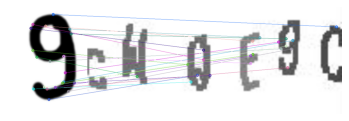

In [76]:
context_shape_match("input/9.png","input/test3.jpg", visual_num=20, N=200, angle=12, distance=[0,1,2,3,4])

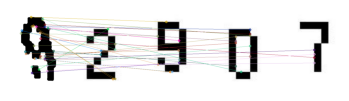

In [85]:
img = context_shape_match("input/9M.png","input/2907.jpg", visual_num=30, N=200, angle=12, distance=[0,1,2,3,4,5,6,7])

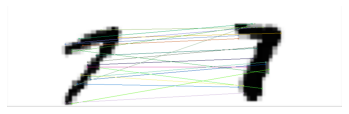

In [89]:
context_shape_match("input/7-1.png","input/7-2.png", visual_num=20, N=100, angle=16, distance=[0,0.125,0.25,0.5,1.0,2.0])